# Importing Libraries and Loading Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import random
data = np.load('/content/mineral-spectra_denoised.npz', allow_pickle=True)
original_data = data['spectra']


# Adding Gaussian and Poisson Noise

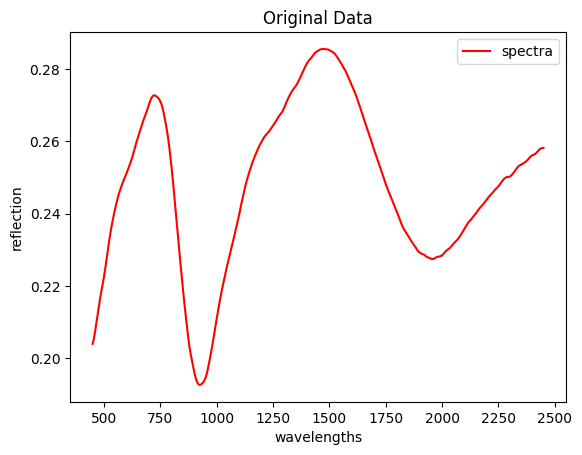

In [ ]:
mean = 0
std_deviation = 25
#adding seed
rnd_seed = 42
rng = np.random.default_rng(seed=rnd_seed)
#change 0.0001 to 0.0001
gaussian_noise = 0.0001 * rng.normal(mean, std_deviation, original_data.shape)
#gaussian_noisy_data = original_data + np.random.normal(mean, std_deviation, original_data.shape)
# Add Poisson noise
lambda_value = 10
#change 0.001 to 0.0001
poisson_noise =  0.001 * (rng.poisson(lambda_value, original_data.shape) - lambda_value)
#poisson_noisy_data = np.random.poisson(lambda_value, original_data.shape)

plt.plot(data['wavelengths'], original_data[0].T, color='red', label='spectra')
plt.xlabel('wavelengths')
plt.ylabel('reflection')
plt.title('Original Data')
plt.legend()
plt.show()

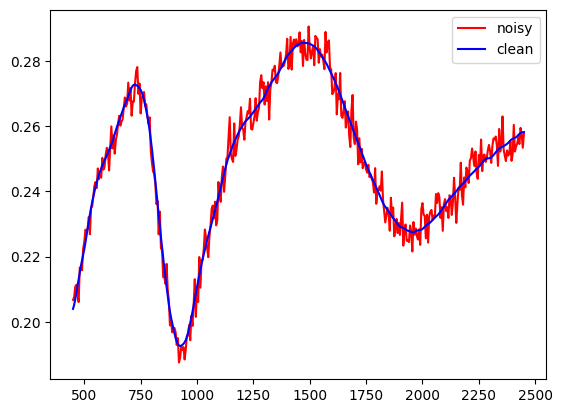

In [ ]:
# combining two noise
noisy_data = original_data + gaussian_noise + poisson_noise
# save the noisy data to a new .npz file
np.savez('noisy_data.npz', data_n=noisy_data)
lables = data['spectra']
plt.plot(data['wavelengths'], noisy_data[0].T, color='red', label='noisy')
plt.plot(data['wavelengths'], lables[0].T, color='blue', label='clean')
plt.legend()

In [ ]:
rnd_seed = 42
rng = np.random.default_rng(seed=rnd_seed)
num_samples = 674
input_length = 401
X = np.random.random((num_samples, input_length , 1))  # Example input data
#y = np.sin(np.linspace(0, 10, input_length)) + np.random.normal(0, 0.2, num_samples)  # Example output data
# Splitting the data into training, validation, and test sets

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(noisy_data, lables, test_size=0.2, random_state=42)

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(noisy_data, lables, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2 / (1-0.2), random_state=42)

index_train, index_test, _, _ = train_test_split(np.arange(len(noisy_data)), np.arange(len(noisy_data)), test_size=0.2, random_state=42)
index_train, index_val, _, _ = train_test_split(index_train, index_train, test_size=0.2 / (1-0.2), random_state=42)

#X_train, X_val, y_train, y_val = train_test_split(noisy_data, lables, test_size=0.2, random_state=42)

In [ ]:
print("Original set - Input shape:", noisy_data.shape, "Output shape:", lables.shape)
print("Training set - Input shape:", X_train.shape, "Output shape:", y_train.shape)
print("Validation set - Input shape:", X_val.shape, "Output shape:", y_val.shape)
print("Testing set - Input shape:", X_test.shape, "Output shape:", y_test.shape)



Original set - Input shape: (674, 401) Output shape: (674, 401)
Training set - Input shape: (404, 401) Output shape: (404, 401)
Validation set - Input shape: (135, 401) Output shape: (135, 401)
Testing set - Input shape: (135, 401) Output shape: (135, 401)


# CNN filtering

Epoch 1/5
13/13 [==============================] - 3s 166ms/step - loss: 0.0481 - val_loss: 0.0179
Epoch 2/5
13/13 [==============================] - 1s 110ms/step - loss: 0.0096 - val_loss: 0.0067
Epoch 3/5
13/13 [==============================] - 1s 115ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 4/5
13/13 [==============================] - 1s 106ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 5/5
5/5 [==============================] - 0s 27ms/step - loss: 0.0014
Test Loss: 0.0013628709129989147
5/5 [==============================] - 0s 25ms/step
[[0.16602224 0.16588706 0.17459024 ... 0.2611547  0.2638821  0.25940323]
 [0.20837584 0.1981225  0.19347847 ... 0.27343053 0.27226564 0.28440973]
 [0.25170943 0.25572863 0.26819617 ... 0.35428968 0.35489565 0.34889004]
 ...
 [0.19145739 0.19686636 0.19074894 ... 0.28293967 0.2834317  0.282193  ]
 [0.15220734 0.1492428  0.16421576 ... 0.2836043  0.287354   0.27920756]
 [0.13497485 0.13224529 0.12754115 ... 0.19123738 0.19291636 0.19990292]

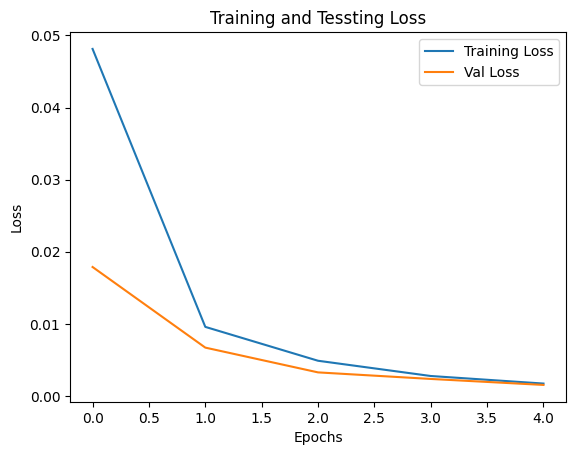

In [ ]:
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
#from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.layers import Conv1D, MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(input_length, 1)))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
#model.add(Dense(64, activation='relu'))
model.add(Dense(input_length))  # Output layer with 1 neuron for regression

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
denoised_data = model.predict(X_test)

print(denoised_data)
len(denoised_data)

model.save_weights("model.h5")
model.summary()



# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Tessting Loss')
plt.legend()
plt.show()





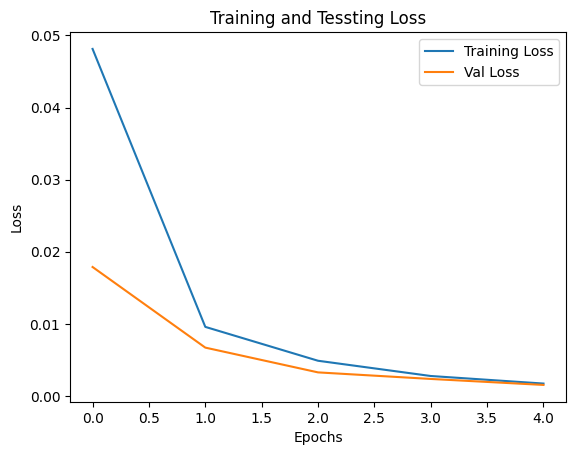

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Tessting Loss')
plt.legend()
plt.show()

In [ ]:
denoised_data = model.predict(noisy_data)

22/22 [==============================] - 0s 15ms/step


In [ ]:
denoised_data

array([[0.20868099, 0.2121792 , 0.20879911, ..., 0.26760373, 0.26224744,
        0.26647213],
       [0.25964594, 0.25920096, 0.2594816 , ..., 0.337884  , 0.3346041 ,
        0.33844882],
       [0.11418481, 0.1142293 , 0.11307783, ..., 0.15240924, 0.15029843,
        0.15121442],
       ...,
       [0.33080363, 0.34054336, 0.3370569 , ..., 0.43538317, 0.4323586 ,
        0.4337427 ],
       [0.31306502, 0.32143065, 0.31944114, ..., 0.41301546, 0.4122557 ,
        0.41495645],
       [0.29484177, 0.30288488, 0.30051124, ..., 0.39103824, 0.38933027,
        0.39066762]], dtype=float32)

# Median Filtering

In [ ]:
import numpy
from PIL import Image


def median_filter(data, filter_size):
    temp = []
    indexer = filter_size // 2
    data_final = []
    data_final = numpy.zeros((len(data),len(data[0])))
    for i in range(len(data)):

        for j in range(len(data[0])):

            for z in range(filter_size):
                if i + z - indexer < 0 or i + z - indexer > len(data) - 1:
                    for c in range(filter_size):
                        temp.append(0)
                else:
                    if j + z - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for k in range(filter_size):
                            temp.append(data[i + z - indexer][j + k - indexer])

            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []
    return data_final



removed_noise = median_filter(original_data, 2)
removed_noise

array([[0.20392933, 0.20392933, 0.20516114, ..., 0.25789142, 0.25804418,
        0.        ],
       [0.24714845, 0.24714845, 0.24888915, ..., 0.34030721, 0.34045073,
        0.        ],
       [0.12858731, 0.24714845, 0.24888915, ..., 0.34030721, 0.34045073,
        0.        ],
       ...,
       [0.32822165, 0.39672509, 0.39771602, ..., 0.51763892, 0.51795495,
        0.        ],
       [0.30000517, 0.32822165, 0.3289201 , ..., 0.46567765, 0.46609393,
        0.        ],
       [0.27072245, 0.30000517, 0.3006067 , ..., 0.45067888, 0.45119926,
        0.        ]])

# Gaussian Smoothening Filter

In [ ]:
import scipy.ndimage as ndimage

In [ ]:
img = ndimage.gaussian_filter(original_data, sigma=(0.4), order=0)

# Wavelet Denoising

In [ ]:
from  skimage.restoration._denoise import denoise_wavelet

In [ ]:
denoised_img = denoise_wavelet(original_data, sigma=0.5, rescale_sigma=True)

# Comparison

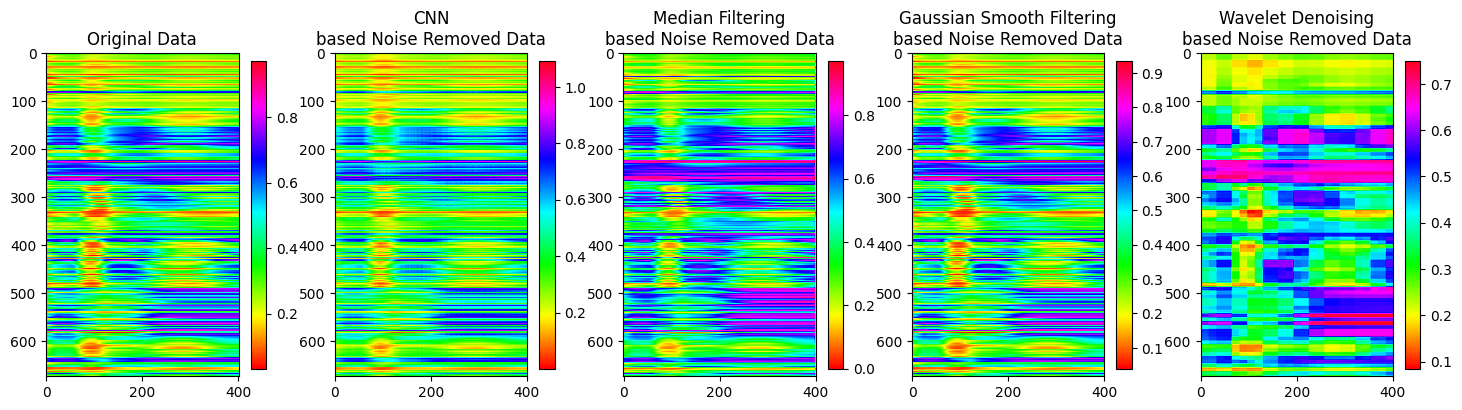

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(18,20))
a = ax[0].imshow(original_data,cmap="hsv",interpolation="spline36")
ax[0].set_title("Original Data")
fig.colorbar(a, shrink=0.2)

b = ax[1].imshow(denoised_data,cmap="hsv",interpolation="spline36")
ax[1].set_title("CNN\nbased Noise Removed Data")
fig.colorbar(b, shrink=0.2)

c = ax[2].imshow(removed_noise,cmap="hsv",interpolation="spline36")
ax[2].set_title("Median Filtering\nbased Noise Removed Data")
fig.colorbar(c, shrink=0.2)


d = ax[3].imshow(img,cmap="hsv",interpolation="spline36")
ax[3].set_title("Gaussian Smooth Filtering\nbased Noise Removed Data")
fig.colorbar(d, shrink=0.2)

e = ax[4].imshow(denoised_img,cmap="hsv",interpolation="spline36")
ax[4].set_title("Wavelet Denoising\nbased Noise Removed Data")
fig.colorbar(e, shrink=0.2)
